In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

# Introduction

The United States Social Security Administration (SSA) has made available data on the frequency of baby names from 1880 through the present. There are many things you might want to do with the data set:

- Visualize the proportion of babies given a particular name over time.
- Determine the relative rank of a name.
- Determine the most popular names in each year or the names with largest increases or decreases.
- Analyze trends in names: vowels, consonants, length, overall diversity, changes in spelling, first and last letters.
- Analyze external sources of trends: biblical names, celebrities, demographic changes.

Using the tools in `pandas`, most of the these kinds of analyses are ver straightforward, so we'll walk through many of them. 

# Get Familiar with the Data

As of this writing, the SSA makes available data files, one per year, containing the total number of births for each sex/name combination. The raw archive of these files can be obtained at http://www.ssa.gov/oact/babynames/limits.html.

After downloading the “National data” file `names.zip` and unzipping it, we will have a directory containing a series of files like `yob1880.txt`. As this is a nicely comma-separated form, it can be loaded into a `DataFrame` with `pandas.read_csv()`:

In [2]:
path = r'E:\Python\Lehrbuecher\Machine Learning\Pandas\Python For Data Analysis\ch02\names\yob%d.txt'
names1880 = pd.read_csv(path % 1880, names=['name', 'sex', 'births'])
names1880[:10]

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
5,Margaret,F,1578
6,Ida,F,1472
7,Alice,F,1414
8,Bertha,F,1320
9,Sarah,F,1288


These files only contain names with at least 5 occurrences in each year, so for simplicity’s sake we can use the sum of the births column by sex as the total number of births in that year:

In [3]:
names1880.groupby('sex').births.sum()

sex
F     90993
M    110493
Name: births, dtype: int64

Since the data set is split into files by year, one of the first things to do is to assemble all of the data into a single `DataFrame` and further to add a year column. This is easy to do using `pandas.concat()`:

In [4]:
# 2010 is the last available year right now
years = range(1880, 2011)

pieces = []
columns = ['name', 'sex', 'births']

for year in years:
    frame = pd.read_csv(path % year, names=columns)
    frame['year'] = year
    pieces.append(frame)

# Concatenate everything into a single DataFrame
names = pd.concat(pieces, ignore_index=True)
names

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
5,Margaret,F,1578,1880
6,Ida,F,1472,1880
7,Alice,F,1414,1880
8,Bertha,F,1320,1880
9,Sarah,F,1288,1880


There are a couple things to note here. 

- First, remember that `concat()` glues the `DataFrame` objects together row-wise by default. 
- Secondly, we have to pass `ignore_index=True` because we’re not interested in preserving the original row numbers returned from `read_csv()`. 

So we now have a very large `DataFrame` containing all of the names data.

With this data in hand, we can already start aggregating the data at the year and sex level using `groupby()` or `pivot_table()`.

In [5]:
total_births = names.pivot_table('births', index='year', columns='sex', aggfunc=sum)
total_births.tail()

sex,F,M
year,,
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310
2009,1827643,1973359
2010,1759010,1898382


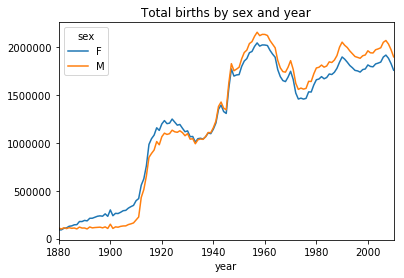

In [6]:
total_births.plot(title='Total births by sex and year')

Next, let’s insert a column `prop` with the fraction of babies given each name relative to the total number of births. A prop value of 0.02 would indicate that 2 out of every 100 babies was given a particular name. Thus, we group the data by year and sex, then add the new column to each group:

In [7]:
def add_prop(group):
    # Integer division floors
    births = group.births.astype(float)
    group['prop'] = births / births.sum()
    return group

names = names.groupby(['year', 'sex']).apply(add_prop)
names

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
5,Margaret,F,1578,1880,0.017342
6,Ida,F,1472,1880,0.016177
7,Alice,F,1414,1880,0.015540
8,Bertha,F,1320,1880,0.014507
9,Sarah,F,1288,1880,0.014155


When performing a group operation like this, it's often valuable to do a sanity check, like verifying that the `prop` column sums to 1 within all the groups. Since this is floating point data, use np.allclose to check that the group sums are sufficiently close to (but perhaps not exactly equal to) 1:

In [8]:
np.allclose(names.groupby(['year', 'sex']).prop.sum(), 1)

True

Now that this is done, we're going to extract a subset of the data to facilitate further analysis: the top 1000 names for each sex/year combination. This is yet another group operation:

In [9]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]

grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)
top1000

name sex  births  year      prop
year sex                                               
1880 F   0             Mary   F    7065  1880  0.077643
         1             Anna   F    2604  1880  0.028618
         2             Emma   F    2003  1880  0.022013
         3        Elizabeth   F    1939  1880  0.021309
         4           Minnie   F    1746  1880  0.019188
         5         Margaret   F    1578  1880  0.017342
         6              Ida   F    1472  1880  0.016177
         7            Alice   F    1414  1880  0.015540
         8           Bertha   F    1320  1880  0.014507
         9            Sarah   F    1288  1880  0.014155
         10           Annie   F    1258  1880  0.013825
         11           Clara   F    1226  1880  0.013474
         12            Ella   F    1156  1880  0.012704
         13        Florence   F    1063  1880  0.011682
         14            Cora   F    1045  1880  0.011484
         15          Martha   F    1040  1880  0.011429
         16           Laura   F    1012  1880  0.011122
         17          Nellie   F     995  1880  0.010935
         18           Grace   F     982  1880  0.010792
         19          Carrie   F     949  1880  0.010429
         20           Maude   F     858  1880  0.009429
         21           Mabel   F     808  1880  0.008880
         22          Bessie   F     794  1880  0.008726
         23          Jennie   F     793  1880  0.008715
         24        Gertrude   F     787  1880  0.008649
         25           Julia   F     783  1880  0.008605
         26          Hattie   F     769  1880  0.008451
         27           Edith   F     768  1880  0.008440
         28          Mattie   F     704  1880  0.007737
         29            Rose   F     700  1880  0.007693
...                     ...  ..     ...   ...       ...
2010 M   1677617       Yair   M     201  2010  0.000106
         1677616      Talan   M     201  2010  0.000106
         1677614      Keyon   M     201  2010  0.000106
         1677613       Kael   M     201  2010  0.000106
         1677618   Demarion   M     200  2010  0.000105
         1677619     Gibson   M     200  2010  0.000105
         1677620     Reagan   M     200  2010  0.000105
         1677621  Cristofer   M     199  2010  0.000105
         1677622     Daylen   M     199  2010  0.000105
         1677623     Jordon   M     199  2010  0.000105
         1677624    Dashawn   M     198  2010  0.000104
         1677625      Masen   M     198  2010  0.000104
         1677629      Rowen   M     197  2010  0.000104
         1677631     Yousef   M     197  2010  0.000104
         1677630   Thaddeus   M     197  2010  0.000104
         1677628      Kadin   M     197  2010  0.000104
         1677627     Dillan   M     197  2010  0.000104
         1677626   Clarence   M     197  2010  0.000104
         1677634      Slade   M     196  2010  0.000103
         1677632    Clinton   M     196  2010  0.000103
         1677633    Sheldon   M     196  2010  0.000103
         1677636    Keshawn   M     195  2010  0.000103
         1677637   Menachem   M     195  2010  0.000103
         1677635     Joziah   M     195  2010  0.000103
         1677638     Bailey   M     194  2010  0.000102
         1677639     Camilo   M     194  2010  0.000102
         1677640     Destin   M     194  2010  0.000102
         1677641     Jaquan   M     194  2010  0.000102
         1677642     Jaydan   M     194  2010  0.000102
         1677645     Maxton   M     193  2010  0.000102

[261877 rows x 5 columns]

We’ll use this Top 1,000 data set in the following investigations into the data.

# Analyzing Naming Trends

With the full data set and Top 1,000 data set in hand, we can start analyzing various naming trends of interest. Splitting the Top 1,000 names into the boy and girl portions is easy to do first:

In [10]:
boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']

Simple time series, like the number of Johns or Marys for each year can be plotted but require a bit of munging to be a bit more useful. Let’s form a pivot table of the total number of births by year and name:

d:\Anaconda3\lib\site-packages\pandas\core\reshape\pivot.py:135: FutureWarning: 'year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002034BFD32E8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000002034EA295F8>], dtype=object)

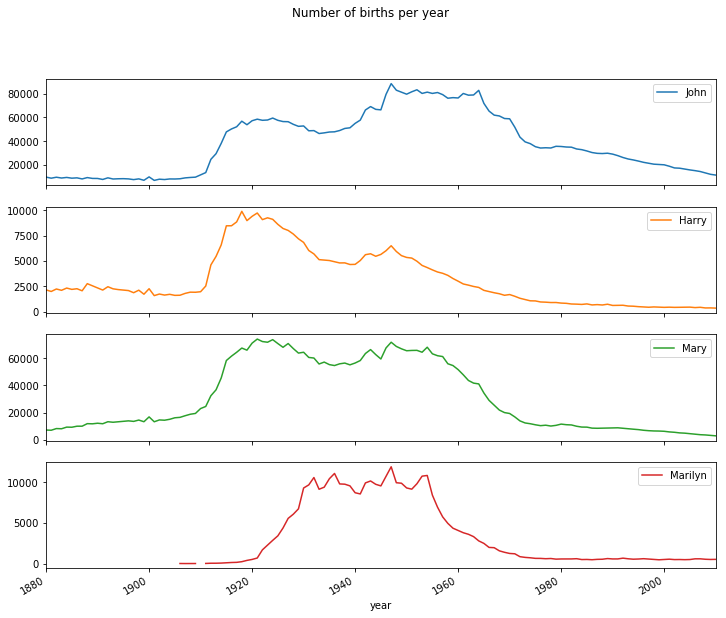

In [11]:
total_births = top1000.pivot_table('births', index='year', columns='name', aggfunc=sum)
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]
subset.plot(subplots=True, figsize=(12, 10), grid=False, title="Number of births per year")

On looking at this, you might conclude that these names have grown out of favor with the American population. But the story is actually more complicated than that, as will be explored in the next section.

# Measuring the Increase in Naming Diversity

One explanation for the decrease in plots above is that fewer parents are choosing common names for their children. This hypothesis can be explored and confirmed in the data. One measure is the proportion of births represented by the top 1000 most popular names, which we aggregate and plot by year and sex. So we can see that, indeed, there appears to be increasing name diversity (decreasing total proportion in the top 1,000). 

d:\Anaconda3\lib\site-packages\pandas\core\reshape\pivot.py:135: FutureWarning: 'year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)
d:\Anaconda3\lib\site-packages\pandas\core\reshape\pivot.py:135: FutureWarning: 'sex' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)


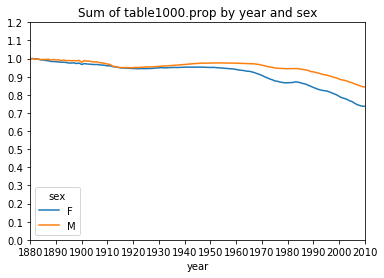

In [12]:
table = top1000.pivot_table('prop', index='year', columns='sex', aggfunc=sum)
table.plot(title='Sum of table1000.prop by year and sex', yticks=np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10))

Another interesting metric is the number of distinct names, taken in order of popularity from highest to lowest, in the top 50% of births. This number is a bit more tricky to compute. Let’s consider just the boy names from 2010:

In [13]:
df_2010 = boys[boys.year == 2010]
df_2010.head()

name sex  births  year      prop
year sex                                             
2010 M   1676644    Jacob   M   21875  2010  0.011523
         1676645    Ethan   M   17866  2010  0.009411
         1676646  Michael   M   17133  2010  0.009025
         1676647   Jayden   M   17030  2010  0.008971
         1676648  William   M   16870  2010  0.008887

After sorting prop in descending order, we want to know how many of the most popular names it takes to reach 50%. We could write a for loop to do this, but a vectorized `NumPy` way is a bit more clever. Taking the cumulative sum, `cumsum()`, of prop then calling the method `searchsorted()` returns the position in the cumulative sum at which 0.5 would need to be inserted to keep it in sorted order:

In [14]:
prop_cumsum_2010 = df_2010.sort_values(by='prop', ascending=False).prop.cumsum()
prop_cumsum_2010[:10]

year  sex         
2010  M    1676644    0.011523
           1676645    0.020934
           1676646    0.029959
           1676647    0.038930
           1676648    0.047817
           1676649    0.056579
           1676650    0.065155
           1676651    0.073414
           1676652    0.081528
           1676653    0.089621
Name: prop, dtype: float64

In [15]:
prop_cumsum_2010.searchsorted(0.5) + 1

array([117], dtype=int64)

Since arrays are zero-indexed, adding 1 to this result gives you a result of 117. By contrast, in 1900 this number was much smaller:

In [16]:
df_1900 = boys[boys.year == 1900]
prop_cumsum_1900 = df_1900.sort_values(by='prop', ascending=False).prop.cumsum()
prop_cumsum_1900.searchsorted(0.5) + 1

array([25], dtype=int64)

It should now be fairly straightforward to apply this operation to each year/sex combination; `groupby()` those fields and `apply()` a function returning the count for each group:

In [17]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    index05 = group.prop.cumsum().searchsorted(q) + 1
    return index05[0]

diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')
diversity.head()

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'sex' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


sex,F,M
year,,
1880,38,14
1881,38,14
1882,38,15
1883,39,15
1884,39,16


This resulting `DataFrame` diversity now has two time series, one for each sex, indexed by year. This can be plotted as before.

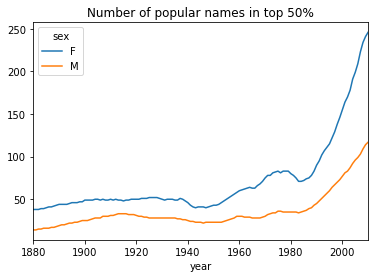

In [18]:
diversity.plot(title="Number of popular names in top 50%")

As you can see, girl names have always been more diverse than boy names, and they have only become more so over time. Further analysis of what exactly is driving the diversity, like the increase of alternate spellings, is left to the reader.

# The “Last Letter” Revolution

In 2007, a baby name researcher Laura Wattenberg pointed out on her website (http://www.babynamewizard.com) that the distribution of boy names by final letter has changed significantly over the last 100 years. To see this, we first aggregate all of the births in the full data set by year, sex, and final letter. Then we select out three representative years spanning the history and print the first few rows.

In [19]:
# extract the last letter from name column
get_last_letter = lambda x: x[-1]
last_letters = names.name.map(get_last_letter)
last_letters.name = 'last_letter'

table = names.pivot_table('births', index=last_letters, columns=['sex', 'year'], aggfunc=sum)
subtable = table.reindex(columns=[1910, 1960, 2010], level='year')
subtable.head()

sex                 F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b                 NaN     694.0     450.0    411.0    3912.0   38859.0
c                 5.0      49.0     946.0    482.0   15476.0   23125.0
d              6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e            133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

Next, normalize the table by total births to compute a new table containing proportion of total births for each sex ending in each letter:

In [20]:
subtable.sum()

sex  year
F    1910     396416.0
     1960    2022062.0
     2010    1759010.0
M    1910     194198.0
     1960    2132588.0
     2010    1898382.0
dtype: float64

After calculating the letter proportions, we can make bar plots for each sex broken down by year.

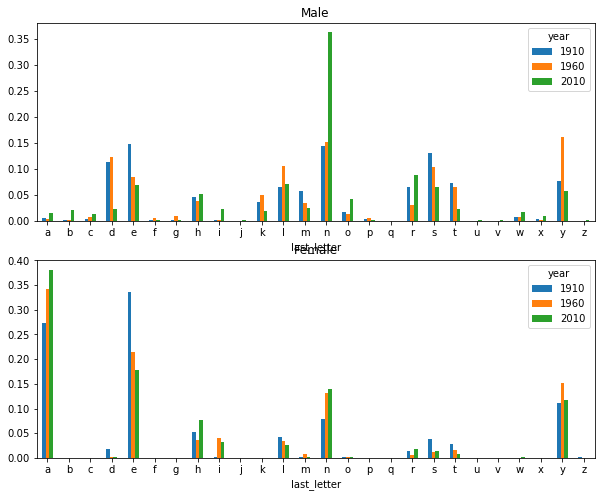

In [21]:
letter_prop = subtable / subtable.sum().astype(float)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female')

As we can see, boy names ending in “n” have experienced significant growth since the 1960s. Going back to the full table created above, we again normalize by year and sex and select a subset of letters for the boy names, finally transposing to make each column a time series:

In [22]:
letter_prop = table / table.sum().astype(float)
dny_ts = letter_prop.loc[['d', 'n', 'y'], 'M'].T
dny_ts.head()

last_letter,d,n,y
year,,,
1880,0.083055,0.153213,0.075760
1881,0.083247,0.153214,0.077451
1882,0.085340,0.149560,0.077537
1883,0.084066,0.151646,0.079144
1884,0.086120,0.149915,0.080405


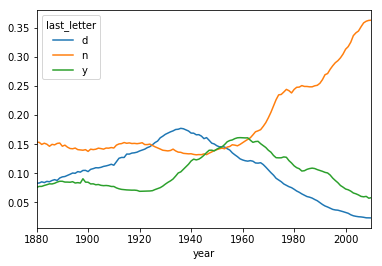

In [23]:
dny_ts.plot()

# Boy Names that Became Girl Names (and vice versa)

Another fun trend is looking at boy names that were more popular with one sex earlier in the sample but have “changed sexes” in the present. One example is the name Lesley or Leslie. Going back to the top1000 dataset, I compute a list of names occurring in the dataset starting with 'lesl':

In [24]:
all_names = top1000.name.unique()
mask = np.array(['lesl' in x.lower() for x in all_names])
lesley_like = all_names[mask]
lesley_like

array(['Leslie', 'Lesley', 'Leslee', 'Lesli', 'Lesly'], dtype=object)

From there, we can filter down to just those names and sum births grouped by name to see the relative frequencies:

In [25]:
filtered = top1000[top1000.name.isin(lesley_like)]
filtered.groupby('name').births.sum()

name
Leslee      1082
Lesley     35022
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

Next, let’s aggregate by sex and year and normalize within year:

In [26]:
table = filtered.pivot_table('births', index='year', columns='sex', aggfunc='sum')
table = table.div(table.sum(1), axis=0)
table.tail()

d:\Anaconda3\lib\site-packages\pandas\core\reshape\pivot.py:135: FutureWarning: 'year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)
d:\Anaconda3\lib\site-packages\pandas\core\reshape\pivot.py:135: FutureWarning: 'sex' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)


sex,F,M
year,,
2006,1.0,NaN
2007,1.0,NaN
2008,1.0,NaN
2009,1.0,NaN
2010,1.0,NaN


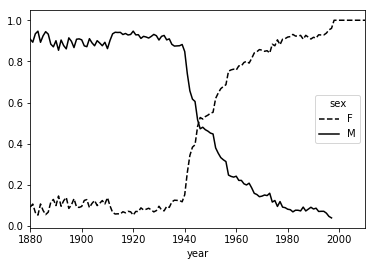

In [27]:
table.plot(style={'M': 'k-', 'F': 'k--'})